# Wide & Deep Learning for Recommender Systems
- Wide Component와 Deep Component의 장점을 합친 추천 모델
- Wide model
    - memorization(기억)
    - ex) 이전에 먹었던 음식이 '햄버거(bugers)' 이면 불고기버거를 추천해주는 모델. 하지만 같은 패스트푸드인 피자를 추천하지는 못한다.
- Deep model
    - generalization
    - query를 카테고리화 시켜서 그 범주 내에 있는 item을 추천함
    - ex) 위의 예제에서 유저가 햄버거를 클릭, 검색 시 피자를 추천할 수 있음. but, over-generalization 되는 경우가 발생함
    - over-generalization
        - '따뜻한 아메리카노' 검색 시 '커피'라는 일반화 범주에서 '아이스 라떼'를 추천 할 수 있다는 것. 
        - 유저는 따뜻한 음료를 원하고 라떼를 싫어할 수 있지만 전혀 다른 결과를 예측할 수 있는 가능성이 있음.


## References
- [구글에서 발표한 논문](https://arxiv.org/pdf/1606.07792.pdf)
- [텐서플로우 튜토리얼 (tensorflow v1)](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/wide_and_deep/)
- [참고용 소스 (tensorflow v2)](https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b)
- [참고 블로그](https://bcho.tistory.com/tag/wide%20and%20deep%20model)

***


## Wide & Deep 모델이란?
- linear 모델의 장점과 neural network(신경망)의 장점을 합치는 모델이다.
- 즉, 선형 모델의 저장법(memorization)과 신경망의 일반화(generalization)의 강점을 합친 모델이다.
- 이 방법은 sparse 입력 feature의 regression 문제와 classification 문제에 유용하다.

### 모델의 3단계 프로세스
1. wide 부분에 대한 features 선택
    - 사용하길 원하는 sparse base column 과 crossed column 들을 선택한다
2. deep 부분에 대한 features 선택 
    - continuous feature(연속된 열), categorical feature(분류 열)의 embedding dimension, 그리고 hidden layer 크기를 선택한다.
3. 이들을 Wide & Deep 모델에 적용한다.

***

# 튜토리얼

## Setup

## Base Feature Columns 정의
사용할 base categorical feature column 과 continuous feature column 들을 정의하자. 이들 base column 들은 모델의 wide 부분과 deep 부분에 모두 사용될 building block 들이 된다.

In [35]:
import tensorflow as tf
from tensorflow import feature_column as fc

# Categorical base columns. (sparse vector)
real = {
    colname : fc.numeric_column(colname) \
          for colname in \
            ('dep_delay,taxiout,distance').split(',')
}
sparse = {
      'origin' : fc.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : fc.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000)
}

## 모델 생성

### 모델 input 정의

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') \
          for colname in sparse.keys()
})

In [36]:
### 임베딩 만들기

In [37]:
embed = {
       'embed_{}'.format(colname) : fc.embedding_column(col, 10) \
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : fc.indicator_column(col) \
          for colname, col in sparse.items()
}

### 레이어 생성

In [38]:
deep = tf.keras.layers.DenseFeatures(real.values())(inputs)
deep = tf.keras.layers.Dense(64, activation='relu')(deep)
deep = tf.keras.layers.Dense(16, activation='relu')(deep)
output = tf.keras.layers.Dense(1, activation='sigmoid')(deep)
model = tf.keras.Model(inputs, output)

In [39]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
    both = tf.keras.layers.concatenate([deep, wide])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
model = wide_and_deep_classifier(inputs, sparse.values(), real.values(), [64, 16])

In [41]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dep_delay (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
dest (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
distance (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
embed_dest (InputLayer)         [(None,)]            0                                            
______________________________________________________________________________________

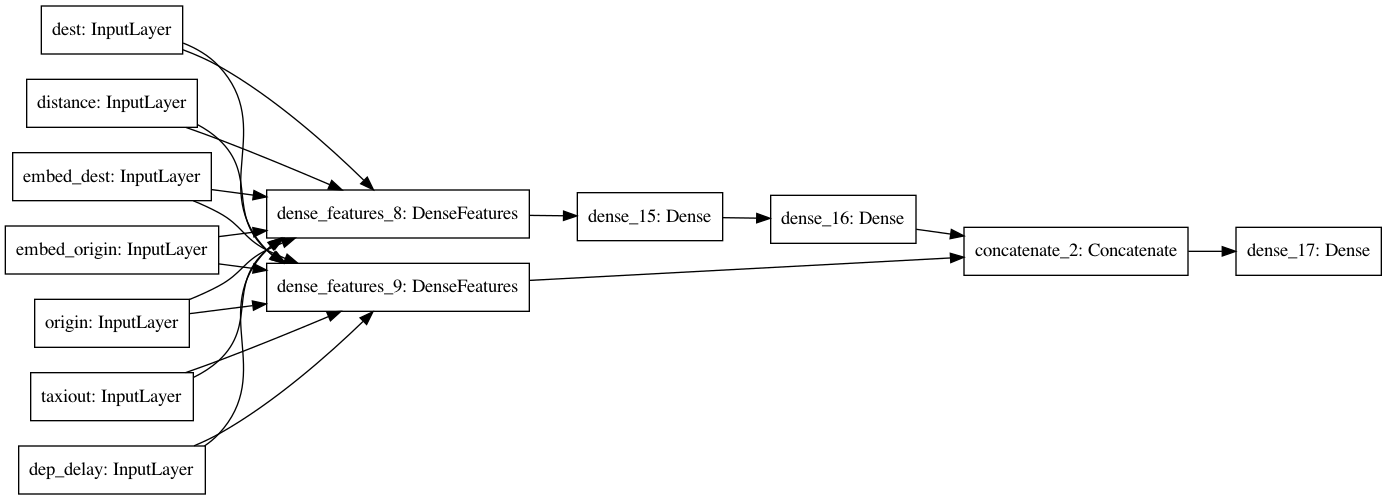

In [42]:
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')


***

## 파라미터 설정

In [83]:
REGION = 'us-central1'
DEVELOP_MODE = True
NBUCKETS = 5 # for embeddings
NUM_EXAMPLES = 1000*1000 # assume 1 million examples
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

TRAIN_DATA = "../dataset/ai-platform_census/adult.data"
TEST_DATA = "../dataset/ai-platform_census/adult.test"

## 데이터 읽기

In [84]:
import pandas as pd

# Define the column names for the data sets.
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
  "marital_status", "occupation", "relationship", "race", "gender",
  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]
LABEL_COLUMN = 'label'
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]



# Read the training and test data sets into Pandas dataframe.
df_train = pd.read_csv(TRAIN_DATA, names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv(TEST_DATA, names=COLUMNS, skipinitialspace=True, skiprows=1)

# label 설정
df_train[LABEL_COLUMN] = (df_train['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df_test[LABEL_COLUMN] = (df_test['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
